[View in Colaboratory](https://colab.research.google.com/github/MChamith/SpatioAE/blob/master/trainae.ipynb)

In [3]:
!git clone https://github.com/MChamith/SpatioAE

fatal: destination path 'SpatioAE' already exists and is not an empty directory.


In [1]:

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras import backend as K
import cv2
import numpy as np
import os
from tqdm import tqdm
import fnmatch
import scipy.misc

TRAIN_DIR ='SpatioAE/Train'
TEST_DIR = 'SpatioAE/Test'
IMG_SIZE = 128



def create_training_set():
  train_data = []
  matches = []
  for root, dirnames, filenames in tqdm(os.walk(TRAIN_DIR)):
    for filename in fnmatch.filter(filenames, "*.tif"):
      path = os.path.join(root, filename)
      img = image.load_img(path, target_size=(128,128), grayscale = True)
      img_array = image.img_to_array(img)
#       print("img array size is " + str(img_array.shape))
#       img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#       img_array = np.expand_dims(img_array, axis = 2)
      train_data.append(np.array(img_array))
          
  np.save('training_data.npy' , train_data)
  
  return train_data

      
    
    
#   for img in tqdm(os.listdir(TRAIN_DIR)):
#     path = os.path.join(TRAIN_DIR, img)
#     img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#     img = np.expand_dims(img, axis = 2)
#     train_data.append(np.array(img))
    
    
#   np.save('training_data.npy' , train_data)
  
#   return train_data


def create_test_set():
  test_data = []
  for img in tqdm(os.listdir(TEST_DIR)):
    path = os.path.join(TEST_DIR, img)
    img = image.load_img(path, target_size=(128,128), grayscale = True)
    img_array =image.img_to_array(img)
    
#     img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#     img = np.expand_dims(img, axis = 2)
    test_data.append(np.array(img_array))
    
    
  np.save('test_data.npy' , test_data)
  return test_data

Using TensorFlow backend.


In [0]:

def model_autoencoder():
  
  input_img  = Input(shape = (128,128,1))  #channel last
  
  x = Conv2D(filters = 32, kernel_size = (3,3),strides = (1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(input_img)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2), strides = (2,2))(x)
  print("layer one conv " + str(x.shape))
  
  x = Conv2D(filters = 48, kernel_size = (3,3),strides = (1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2), strides = (2,2))(x)
  print("layer two conv " + str(x.shape))
  
 
  x = Conv2D(filters = 64, kernel_size = (3,3),strides = (1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2), strides = (2,2))(x)
  print("layer three conv " + str(x.shape))
  
  x = Conv2D(filters = 64, kernel_size = (3,3),strides = (1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  encoded = MaxPooling2D(pool_size = (1,1), strides = (1,1))(x)
  print("layer four conv " + str(encoded.shape))
  
  
  ## decoder branch
  
  x = Conv2D(filters = 48, kernel_size = (3,3),strides = (1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(encoded)
  x = UpSampling2D(size = (2,2))(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  print("layer one deconv " + str(x.shape))
 
  x = Conv2D(filters = 32, kernel_size = (3,3),strides = (1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = UpSampling2D(size = (2,2))(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  print("layer two deconv " + str(x.shape))
  
  x = Conv2D(filters = 32, kernel_size = (3,3),strides = (1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = UpSampling2D(size = (2,2))(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  print("layer three deconv " + str(x.shape))
  decoded = Conv2D(filters = 1, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'sigmoid')(x)
  print("output" + str(decoded.shape))

  
  
  autoencoder = Model(input_img, decoded)
  
  return autoencoder
  

In [6]:
get_data = create_training_set()
input_imgs = np.load('training_data.npy')
input_imgs = input_imgs.astype('float32') / 255.
print(input_imgs.shape)
K.clear_session()
autoencoder = model_autoencoder()
autoencoder.compile(optimizer = 'adam' , loss = 'mean_squared_error')

autoencoder.fit(input_imgs,input_imgs,  epochs =50, batch_size= 100)
  
    

35it [00:06,  5.45it/s]


(6800, 128, 128, 1)
layer one conv (?, 64, 64, 32)
layer two conv (?, 32, 32, 48)
layer three conv (?, 16, 16, 64)
layer four conv (?, 16, 16, 64)
layer one deconv (?, 32, 32, 48)
layer two deconv (?, 64, 64, 32)
layer three deconv (?, 128, 128, 32)
output(?, 128, 128, 1)
Epoch 1/50
6800/6800 [==============================] - 21s 3ms/step - loss: 0.0089
Epoch 2/50
6800/6800 [==============================] - 20s 3ms/step - loss: 0.0046
Epoch 3/50
6800/6800 [==============================] - 20s 3ms/step - loss: 0.0039
Epoch 4/50
6800/6800 [==============================] - 20s 3ms/step - loss: 0.0035
Epoch 5/50
6800/6800 [==============================] - 20s 3ms/step - loss: 0.0031
Epoch 6/50
6800/6800 [==============================] - 20s 3ms/step - loss: 0.0029
Epoch 7/50
6800/6800 [==============================] - 20s 3ms/step - loss: 0.0027
Epoch 8/50
6800/6800 [==============================] - 20s 3ms/step - loss: 0.0025
Epoch 9/50
6800/6800 [==============================] -

In [23]:
get_test_data = create_test_set()
test_imgs = np.load('test_data.npy')
test_imgs = test_imgs.astype('float32') / 255.
print(input_imgs.shape)

decode_imgs = autoencoder.predict(test_imgs)

100%|██████████| 200/200 [00:00<00:00, 1042.10it/s]


(6800, 128, 128, 1)


In [0]:
import matplotlib.pyplot as plt
from PIL import Image

for n in range(10):
  sq_img = np.squeeze(test_imgs[n], axis = 2)
  sq_img = sq_img*255
  sq_img = sq_img.astype('uint8')

  dec_img = np.squeeze(decode_imgs[n], axis = 2)
  dec_img = dec_img*255
  dec_img = dec_img.astype('uint8')

  scipy.misc.imsave('testimage'+str(n)+'.png', sq_img)
  scipy.misc.imsave('dec'+str(n)+'.png', dec_img)


# plt.imshow(sq_img)

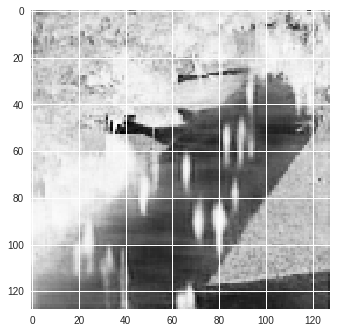

In [35]:
plt.imshow(np.squeeze(decode_imgs[1], axis = 2))
  

In [2]:
autoencoder.evaluate(test_imgs, test_imgs)


NameError: ignored

In [0]:
import pydot
import graphviz
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png',show_shapes=True)

In [10]:
!apt-get install -q graphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
